In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gedsk

In [2]:
from freeqdsk import geqdsk

In [3]:
import scipy.integrate as spi

### Field Following Separatrix Curve Generation Algorithm
#### Introduction
What is Separatrix Curve: Each poloidal field has some saddle points, and the separatrix curve is simply the contour curve, i.e. the points that have the same value of Psi as the saddle point is called the separatrix curve. So, it is very easy to get the separatrix curve by using the contour plot of Psi and this is done in the allCriPoints.ipynb file.

But now, we will use another method to compute the separatrix curve. And it is called the field following method.

#### Field Following Method
The terminologies:

$B$ = Magnetic field <br>
$\psi$ = $B.S$ = Magnetic flux ($Wb$) but in geqdsk file it's $Wb/rad$. <br>
$I$ = plasma current ($A$)<br>
$I_{pol}$ = poloidal current ($A$)<br>

$B_r$ = $-\frac{1}{R} \frac{\partial \psi}{\partial z}$ <br>
$B_z$ = $\frac{1}{R} \frac{\partial \psi}{\partial R}$ <br>
$B_t$ = $\frac{I_{pol}}{R}$ 

$I_{pol}$ is given as a 1D array in the geqdsk file.
<br>

This is described in more detail in Usman's thesis. (available in the TOMMS box folder)


In [52]:
# get the data from the file
filename = r"D:\Codes\AllSamples\N-g127975.00430\g127975.00430"
#filename = "geqdsks\g096333.03337"
data = gedsk.read_gedsk(filename)
wall_points = gedsk.get_wall_points(filename)
psi = gedsk.get_psi(data)
if wall_points is not None:
    print("Wall points found")
else:
    print("Wall points not found")

Wall points found


In [53]:
bounds = gedsk.get_bounds(data)
x, y = gedsk.get_xy(data)
xx, yy = gedsk.get_meshgrid_for_psi(data)
spline = gedsk.get_spline_for_psi(psi, x, y)

In [54]:
# now get all the critical points and sort them
all_critical_points = gedsk.find_all_critical_points_using_root(spline, bounds,nx=20, ny=20, method='hybr')

# sort the critical points without using the wall points
sorted_points = gedsk.sort_critical_points(all_critical_points, spline, bounds, None)

# sort the critical points using the wall points
sorted_points_with_wall = gedsk.sort_critical_points(all_critical_points, spline, bounds, wall_points)

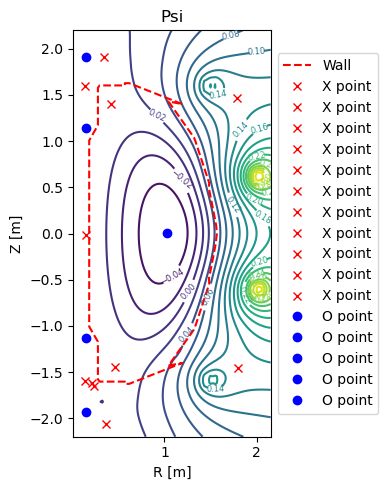

In [55]:
fig, ax = gedsk.plot_sorted_points_with_contour_with_wall(psi, xx, yy, sorted_points, filename)
plt.show()

#### The Algorithm
Now we have everything to compute the separatrix curve. Now we will use the field following method to compute the separatrix curve.

In [86]:
# get the ipol 1D array and generate the ipol function using interp1d
ipol = data['fpol']

# create a linear interpolation function using the ipol array and map from 0 to 1
# the function gets value from 0 to 1 and returns the value of the ipol at that point
def fpol(x):
    global ipol
    return np.interp(x, np.linspace(0, 1, len(ipol)), ipol)

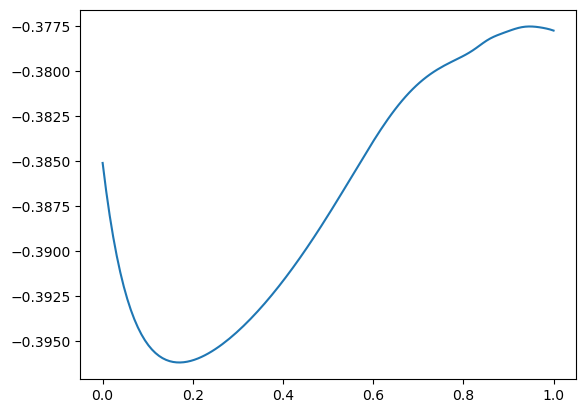

In [110]:
# plot fpol
x = np.linspace(0, 1, len(ipol))
plt.plot(x, ipol)
plt.show()

In [87]:
sorted_points_with_wall

{'out_of_wall': [(0.13522080646419685, 1.5922800114983877),
  (0.1519350751172551, -1.135704136625905),
  (0.1525479259395292, 1.1448088949905948),
  (0.21834088485618913, -1.6164604637144928),
  (0.14822321538712685, -0.011819451978645194),
  (0.15191134993755182, 1.9061039265442814),
  (0.14630739103769005, -1.9355934516093836),
  (0.13727010150569122, -1.5955717433079504),
  (1.786986570929633, 1.4658918093046032),
  (1.7938164816438729, -1.451883933080269),
  (0.349300950093097, 1.913490844226489),
  (0.3618081164498321, -2.065660134002988),
  (0.2340627513901278, -1.6527516818905843)],
 'saddle': [(0.4661808475089887, -1.4433709953609701),
  (0.42221938845182705, 1.402697336657889)],
 'minimum': [(1.031994768937216, 0.0078100657291840835)]}

In [111]:
# create a function that takes the value of psi and normalizes it to 0 to 1
def psi_norm(psivalue):
    global sorted_points_with_wall
    global spline
    x_point = sorted_points_with_wall['saddle'][0]
    minimum_point = sorted_points_with_wall['minimum'][0]
    max_psi = spline(x_point[0], x_point[1])[0][0]
    min_psi = spline(minimum_point[0], minimum_point[1])[0][0]
    return (psivalue - min_psi) / (max_psi - min_psi)

In [112]:
# create a get_pol_current function that takes the value of psi and returns the value of the poloidal current at that point
def get_pol_current(psivalue):
    norm_psi = psi_norm(psivalue)
    return fpol(norm_psi)

In [113]:
# get the maximum and minimum of psi and plot the poloidal current
max_psi = spline(sorted_points_with_wall['saddle'][0][0], sorted_points_with_wall['saddle'][0][1])[0][0]
min_psi = spline(sorted_points_with_wall['minimum'][0][0], sorted_points_with_wall['minimum'][0][1])[0][0]
max_psi, min_psi

(0.010602155333484183, -0.059227579852099844)

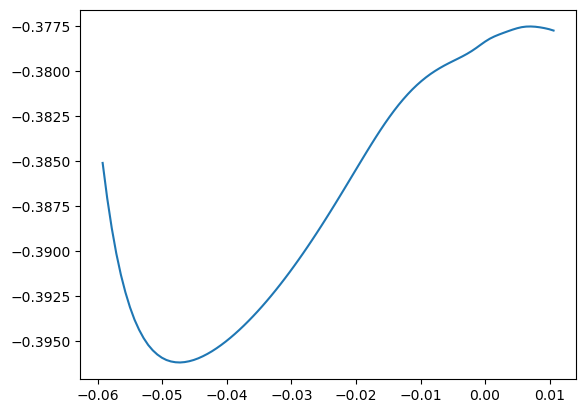

In [114]:
# create a linspace from the minimum to the maximum of psi and get the poloidal current at those points
psi_values = np.linspace(min_psi, max_psi, 100)
pol_current = get_pol_current(psi_values)

# plot the poloidal current
plt.plot(psi_values, pol_current)

### Now do the Line Integrals

In [116]:
def get_dls(t, y):
    R, Z = y
    global spline
    dpsidz = spline(R, Z, dx=0, dy=1)[0][0]
    dpsidr = spline(R, Z, dx=1, dy=0)[0][0]
    psi = spline(R, Z)[0][0]
    I = get_pol_current(psi)
    return (dpsidz * R) / I, (dpsidr * R) / I


In [105]:
# now do the integration of the dls and plot the field lines
R0 = sorted_points_with_wall['saddle'][0][0]
Z0 = sorted_points_with_wall['saddle'][0][1]

In [106]:
R0, Z0

(0.4661808475089887, -1.4433709953609701)

In [117]:
sol = spi.solve_ivp(get_dls, (0, np.pi/2), (R0, Z0), t_eval=np.linspace(0, np.pi/2, 20))

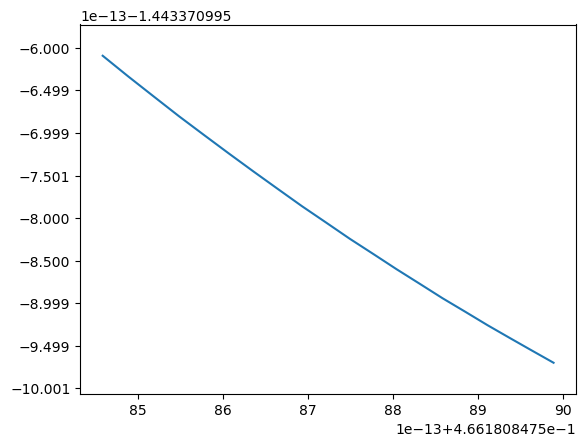

In [118]:
r, z = sol.y
plt.plot(r, z)
# equal aspect ratio
plt.axis('equal')
plt.show()

In [109]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.071e-02 ...  6.929e+00  7.000e+00]
        y: [[ 4.662e-01  4.662e-01 ...  4.662e-01  4.662e-01]
            [-1.443e+00 -1.443e+00 ... -1.443e+00 -1.443e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0